In [8]:
import random
import copy
import matplotlib.pyplot as plt

class GeneticSearch:
    def __init__(self, params):
        self.max = params['max_bounds']
        self.min = params['min_bounds']
        self.chrome_len = len(format(max(self.max + self.min)+20, 'b'))
        self.n = params['dimension']
        self.repr_rate = params['repr_rate']
        self.num_agents = params['num_agents']
        self.code_bits = params['code_bits']
        
        self.max_iters = params['max_iters']
        self.stop_tol = params['stop_tol']
        self.stop_tol_iters = params['stop_tol_iters']
        
        self.fitness_func = params['fitness_function']
        self.constraints = params['constraints']
        
        self.data_collector = {
            'max_fitness': [],
            'best_loc': [],
            'avg_fitness': [],
            'num_mutations': [],
            'num_crossovers': []
        }
        
        self.gray_to_loc, self.loc_to_gray = self.gen_conversion_dicts()
        
        # Initialize agents
        self.gen_agents()

        # Check that the dimensions of everything matches here
        self.curr_max_fit = max([agent.fit for agent in self.agents])
        self.iter_count = 0

    def gen_gray_code(self, n_bit):
        if n_bit == 1:
            gray_list = ['']
        else:
            gray_list = self.gen_gray_code(n_bit - 1)
        
        return ['0'+ code for code in gray_list] + ['1' + code for code in gray_list[::-1]]
    
    def gen_conversion_dicts(self):
        distance_list = [self.max[i] - self.min[i] for i in range(self.n)]
                                                                  
        # We don't want points on bounds because then total distance from represented point is greater
        step_list = [dis/(2**self.code_bits + 1) for dis in distance_list]
        
        locs_list = []
        
        for dim in range(self.n):
            values = [self.min[dim] + step_list[dim]*i for i in range(1, 2**self.code_bits + 1)]
            locs_list.append(values)
        
        gray_list = self.gen_gray_code(self.code_bits)
        
        return [dict(zip(gray_list, locs)) for locs in locs_list], [dict(zip(locs, gray_list)) for locs in locs_list]
    
    def gen_agents(self):
        self.agents = []
        for i in range(self.num_agents):
            loc = tuple(random.choice(list(self.loc_to_gray[i].keys())) for i in range(self.n))
            fitness = self.fitness_func(loc)
            self.agents.append(GeneticAgent(self.loc_to_gene(loc), loc, fitness, params['p_mut'], params['p_cross']))
        
        
    def loc_to_gene(self, location):
        new_genome = []
        
        # Create binary representation for every value in location vector
        for i in range(len(location)):
            chrom = []
            code = self.loc_to_gray[i][location[i]]
            for char in code:
                chrom.append(int(char))

            new_genome += chrom
            
        return new_genome
    
    def gene_to_loc(self, genome):
        
        chroms = [genome[self.code_bits*i:self.code_bits*(i+1)] for i in range(self.n)]
        return tuple(self.gray_to_loc[i][''.join(str(bit) for bit in chroms[i])] for i in range(self.n))

    
    def eval_func(self, agent):
        
        location = self.gene_to_loc(agent.gene)
        agent.loc = location
     
        return self.fitness_func(location)
    
    def step_vdps(self):
        self.repr_pairs = []
        self.reproduce(0)
        
        for pair in self.repr_pairs:
            pair[0].crossover(pair[1]) 
        
        for pair in self.repr_pairs:
            for agent in pair:
                agent.mutate()
        
        for pair in self.repr_pairs:
            for agent in pair:
                agent.fit = self.eval_func(agent)
    
    def step_hw(self):
        best_agent = self.reproduce(1)

        for i in range(len(self.agents)):
            for j in range(i+1, len(self.agents)):
                self.agents[i].crossover(self.agents[j])
                    
        
        for agent in self.agents:
            agent.hw_mutate()
            agent.fit = self.eval_func(agent)
            
        self.agents.append(best_agent)
        return 'Optimum: ' + str(best_agent.loc) + ' Fitness: ' + str(best_agent.fit)
            
    def run(self):
        
        diff = 0
        not_converged = True
        converged_count = 0
        
        while not_converged and (self.iter_count < self.max_iters):
            prev_max_fit = self.curr_max_fit
            self.step_vdps()
#             best = self.step_hw()
            diff = self.curr_max_fit - prev_max_fit
            
            if abs(diff) < self.stop_tol:
                converged_count += 1
            else:
                converged_count = 0
                
            not_converged = True if converged_count < self.stop_tol_iters else False
            
            self.iter_count += 1
#             self.display_2d() if self.iter_count%5 == 0 else None
        
#         print(best)
            
        
    def reproduce(self, step_method):
        fits = [agent.fit for agent in self.agents]
        self.curr_max_fit = max(fits)
        index_max = fits.index(self.curr_max_fit)
        best_agent = self.agents[index_max]
                
        self.data_collector['max_fitness'].append(self.curr_max_fit)
        self.data_collector['best_loc'].append(self.agents[index_max].loc)
        
        fs_adj = [self.curr_max_fit - fit for fit in fits]
        f_sum = sum(fs_adj)
        self.data_collector['avg_fitness'].append(f_sum/self.num_agents)
        fs_norm = [fit/f_sum for fit in fs_adj]
        fs_roulette = self.gen_roulette(fs_norm)
        
        if step_method == 0:
            for i in range(self.repr_rate):
                agent1 = self.roulette_select(fs_roulette, random.random())
                agent2 = self.roulette_select(fs_roulette, random.random())

                self.repr_pairs.append((agent1, agent2))
                
        elif step_method == 1:
            new_agents = []
            for i in range(self.num_agents-1):
                ag = self.roulette_select(fs_roulette, random.random())
                new_agents.append(copy.deepcopy(ag))

            self.agents = new_agents
            return best_agent
        
        
    def gen_roulette(self, fs_norm):
        wheel = [0.0]
        for norm_fit in fs_norm:
            wheel.append(wheel[-1] + norm_fit)
            
        return wheel
        
    def roulette_select(self, roulette, rand):
        for i in range(len(roulette)):
            if rand < roulette[i]:
                return self.agents[i-1]
    
    def display_2d(self):
        #Display current locations of agents
        plt.cla()
        plt.clf()
        x_list = [agent.loc[0] for agent in self.agents]
        y_list = [agent.loc[1] for agent in self.agents]
#         plt.scatter(x_list, y_list)
        plt.hexbin(x_list, y_list, gridsize=50, cmap='inferno')
        plt.show()

    
        

In [9]:
class GeneticAgent:
    def __init__(self, gene, location, fitness, p_mut, p_cross):
        self.loc = location
        self.gene = gene
        self.p_mut = p_mut
        self.p_cross = p_cross
        self.fit = fitness
    
    def crossover(self, other):
        if random.random() < self.p_cross:
            left = random.randint(0, len(self.gene)-1)
            right = random.randint(0, len(self.gene)-1)
            self.gene[left:right+1], other.gene[left:right+1] = other.gene[left:right+1], self.gene[left:right+1]
    
    def mutate(self):
        if random.random() < self.p_mut:
            r = random.randint(0, len(self.gene)-1)
            self.gene[r] ^= 1
            
    def hw_mutate(self):
        for i in range(len(self.gene)):
            if random.random() < self.p_mut:
                self.gene[i] ^= 1
                
    

In [46]:
import math

params = {
    'num_agents': 120,
    'dimension': 2,
#     'fitness_function': lambda tup: -((tup[1] - tup[0]**2)**2 + tup[1]**2),
    'fitness_function': lambda tup: -abs(math.sin((tup[0]**2)/20) + (tup[1]**2)/30),
    'constraints':None,
    'p_mut':.3,
    'p_cross':.7,
    'repr_rate': 10,
    'max_bounds':(10, 10),
    'min_bounds':(-10, -10),
#     'max_bounds':(7, 7),
#     'min_bounds':(-8, -8),
    'max_iters': 300,
    'stop_tol': 10**(-8),
    'stop_tol_iters': 30,
    'code_bits': 15
}

G = GeneticSearch(params)
print(max([agent.fit for agent in G.agents]))

-0.015657636933615913


[-0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913, -0.015657636933615913]


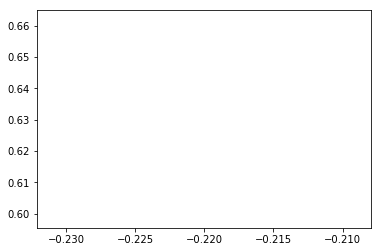

-0.22002502365040044 0.6301687570569747
30


In [47]:
G.run()
    
print(G.data_collector['max_fitness'])
# print(G.data_collector['best_loc'])
xs = [loc[0] for loc in G.data_collector['best_loc']]
ys = [loc[1] for loc in G.data_collector['best_loc']]
plt.plot(xs, ys)
plt.show()
print(xs[-1], ys[-1])
print(G.iter_count)